In [13]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio
from sklearn.manifold import TSNE
from google.colab import drive
import matplotlib.pyplot as plt
nt = [-1] + [35] + [1000]
def load_features(path):
  full_features = torch.load(path)
  ages = full_features[:,:,0]
  features = full_features[:,:,1]
  preds = full_features[:,:,2]
  preds_hard = torch.zeros_like(preds)
  preds_hard[ages>=36] = 1
  return ages,features,preds,preds_hard

def MSE_with_preds(features,ages,preds,coeff = 0.5):
  ordered_ages, index_ages = torch.sort(ages)
  ordered_features, index_features = torch.sort(features)
  ages_ordered_by_features = ages[index_features]
  
  pred_ages = torch.zeros_like(ages)
  for i in range(len(nt) - 1):
        indices = torch.where((ages > nt[i]) * (ages <= nt[i+1]))[0]
        avg = ages[indices].mean()
        pred_ages[torch.where(preds == i)[0]] = avg

  pred_ages =  (1-coeff) * ages_ordered_by_features + pred_ages[index_ages] *coeff
  MSE = (pred_ages - ordered_ages).pow(2).mean().item()

  ordered_features, index_features = torch.sort(features, descending = True)
  
  ages_ordered_by_features = ages[index_features]
  pred_ages = torch.zeros_like(ages)* coeff + (1-coeff) * ages_ordered_by_features

  for i in range(len(nt) - 1):
        indices = torch.where((ages > nt[i]) * (ages <= nt[i+1]))[0]
        avg = ages[indices].mean()
        pred_ages[torch.where(preds == i)[0]] = avg
  pred_ages = (1-coeff) * ages_ordered_by_features + pred_ages[index_ages] *coeff
  
  MSEd  = (pred_ages - ordered_ages).pow(2).mean().item()
  MSE = min(MSE, MSEd)

  return MSE

def MSE_classif(preds,ages):
    pred_ages = torch.zeros_like(ages)
    for i in range(len(nt) - 1):
        indices = torch.where((ages > nt[i]) * (ages <= nt[i+1]))[0]
        avg = ages[indices].mean()
        pred_ages[torch.where(preds == i)[0]] = avg
    return(pred_ages - ages).pow(2).mean().item()

def entropy(features, bins = 100):
  hist= torch.histc(features,bins = bins)
  hist /=hist.sum()
  return - (hist * (hist+1e-21).log2()).sum()

def run_stats(path,coeff = 0.7):
  print(path)
  ages,features,preds,preds_hard = load_features(path)
  print(ages.size())
  all_MSE = np.array([MSE_with_preds(features[i,:],ages[i,:],preds[i,:],0) for i in range (ages.size()[0])])
  all_MSE_with_preds = np.array([MSE_with_preds(features[i,:],ages[i,:],preds_hard[i,:],coeff) for i in range (ages.size()[0])])
  all_MSE_classif = np.array([MSE_classif(preds[i,:],ages[i,:]) for i in range (ages.size()[0])])
  Entropy = np.array([entropy(features[i,:],bins = 100) for i in range (ages.size()[0])])
  return features,preds ,ages,all_MSE, all_MSE_with_preds, all_MSE_classif, Entropy

def normalize(data):
  return (data-np.min(data))/(np.max(data)-np.min(data))

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
features_CE, preds_CE,ages_CE, all_MSE_CE, all_MSE_with_preds_CE, all_MSE_classif_CE, Entropy_CE = run_stats('models_and_features/features_Vanilla.pt',coeff = 0.82)
features_FIERCE,preds_FIERCE,ages_FIERCE, all_MSE_FIERCE, all_MSE_with_preds_FIERCE, all_MSE_classif_FIERCE, Entropy_FIERCE = run_stats('models_and_featuresfeatures_0.2.pt',coeff = 0.68)
features_LS, preds_LS, ages_LS,all_MSE_LS, all_MSE_with_preds_LS, all_MSE_classif_LS, Entropy_LS = run_stats('models_and_featuresfeatures_ls.pt',coeff = 0.93)

/content/gdrive/MyDrive/features_Vanilla.pt
torch.Size([500, 10000])
/content/gdrive/MyDrive/features_0.2.pt
torch.Size([500, 10000])
/content/gdrive/MyDrive/features_ls.pt
torch.Size([500, 10000])


In [ ]:
plt.plot(np.sqrt(all_MSE_with_preds_CE),'blue',label = 'Cross Entropy')
plt.plot(np.sqrt(all_MSE_with_preds_FIERCE),'red',label = 'FIERCE')
plt.plot(np.sqrt(all_MSE_with_preds_LS),'green',label = 'Label Smoothiong')
plt.xlabel('epochs')
plt.ylabel('entropy')
plt.title('Evolution Entropy')
plt.legend()

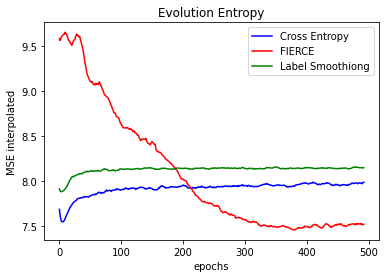

In [ ]:
plt.plot(np.sqrt(moving_average(all_MSE_with_preds_CE,8)),'blue',label = 'Cross Entropy')
plt.plot(np.sqrt(moving_average(all_MSE_with_preds_FIERCE,8)),'red',label = 'FIERCE')
plt.plot(np.sqrt(moving_average(all_MSE_with_preds_LS,8)),'green',label = 'Label Smoothiong')
plt.xlabel('epochs')
plt.ylabel('MSE interpolated')
plt.title('Evolution Entropy')
plt.legend()

In [29]:
def plot_features(features,ages,preds):
  mask_0 = (preds == 0)
  mask_1 = (preds == 1)
  plt.scatter(ages[mask_0],features[mask_0])
  plt.scatter(ages[mask_1],features[mask_1])


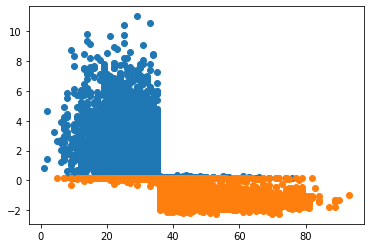

In [30]:
plot_features(features_CE[-1],ages_CE[-1],preds_CE[-1])

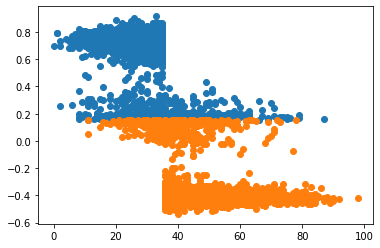

In [37]:
plot_features(features_LS[-1],ages_LS[-1],preds_LS[-1])

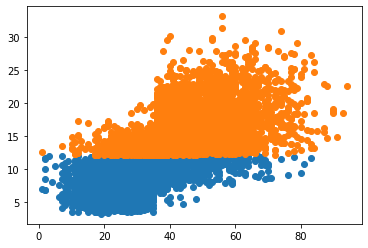

In [33]:
plot_features(features_FIERCE[-1],ages_FIERCE[-1],preds_FIERCE[-1])